In [ ]:
# !pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 38.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
import keras_cv
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt

keras.utils.set_random_seed(31)

### Create EfficientNet Modules

In [3]:
def squeeze_excite_block(inputs, ratio=0.25):
    channels = inputs.shape[-1]
    # squeeze operation (global average pooling)
    x = layers.GlobalAveragePooling2D()(inputs)

    # excitation operation (two FC layers)
    x = layers.Dense(max(1, int(channels * ratio)))(x)
    x = layers.Activation('swish')(x)
    x = layers.Dense(channels)(x)
    x = layers.Activation('sigmoid')(x)

    # reshape for multiplication
    x = layers.Reshape((1, 1, channels))(x)

    # scale the input
    return layers.multiply([inputs, x])

In [4]:
def mbconv_block(inputs, output_channels, expansion_ratio=6, kernel_size=3, stride=1, se_ratio=0.25, drop_rate=0.2):
    channels = inputs.shape[-1]
    expanded_channels = channels * expansion_ratio

    # expansion phase
    if expansion_ratio != 1:
        x = layers.Conv2D(expanded_channels,
                         kernel_size=1,
                         padding='same',
                         use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
    else:
        x = inputs

    # depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=kernel_size,
                              strides=stride,
                              padding='same',
                              use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # squeeze and excitation
    if se_ratio:
        x = squeeze_excite_block(x, ratio=se_ratio)

    # pointwise convolution
    x = layers.Conv2D(output_channels,
                      kernel_size=1,
                      padding='same',
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # skip connection
    if stride == 1 and channels == output_channels:
        if drop_rate:
            x = layers.Dropout(drop_rate, noise_shape=(None, 1, 1, 1))(x)
        x = layers.add([x, inputs])

    return x

In [5]:
def initial_block(inputs, filters, stride=2):
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    return x

In [6]:
def head_block(inputs, num_classes, drop_rate=0.2):
    x = layers.GlobalAveragePooling2D()(inputs)
    if drop_rate:
        x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(num_classes)(x)
    return x

### Prepare the Dataset

In [7]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [8]:
def prepare_dataset(dataset, shuffle:bool=True, augment:bool=False):

    rand_augment = keras_cv.layers.RandAugment(
      value_range=(0, 255), augmentations_per_image=3, magnitude=0.2
    )

    if shuffle:
      dataset = dataset.shuffle(BATCH_SIZE * 1000)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: (rand_augment(x), y),  # RandAugment can process it
            num_parallel_calls=AUTO,
        )

    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTO,
    )

    return dataset.prefetch(AUTO)

In [9]:
def fetch_and_augment_cifar10() -> tuple:
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # partition the train data to obtain a val data
    num_samples = x_train.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices, )     # shuffle to avoid bias

    x_train, y_train = x_train[indices], y_train[indices]

    val_size = int(0.1 * num_samples)

    # 45000 train and 5000 val datapoints
    x_val, y_val = x_train[:val_size], y_train[:val_size]
    x_train, y_train = x_train[val_size:], y_train[val_size:]


    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test,  y_test))

    train_ds_original = prepare_dataset(train_ds)
    train_ds = prepare_dataset(train_ds, shuffle=True, augment=True)
    val_ds = prepare_dataset(val_ds)
    test_ds = prepare_dataset(test_ds, shuffle=False)

    return (train_ds, val_ds, test_ds, y_test, train_ds_original)

In [10]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = 32

train_ds, val_ds, test_ds, y_test, train_ds_original = fetch_and_augment_cifar10()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


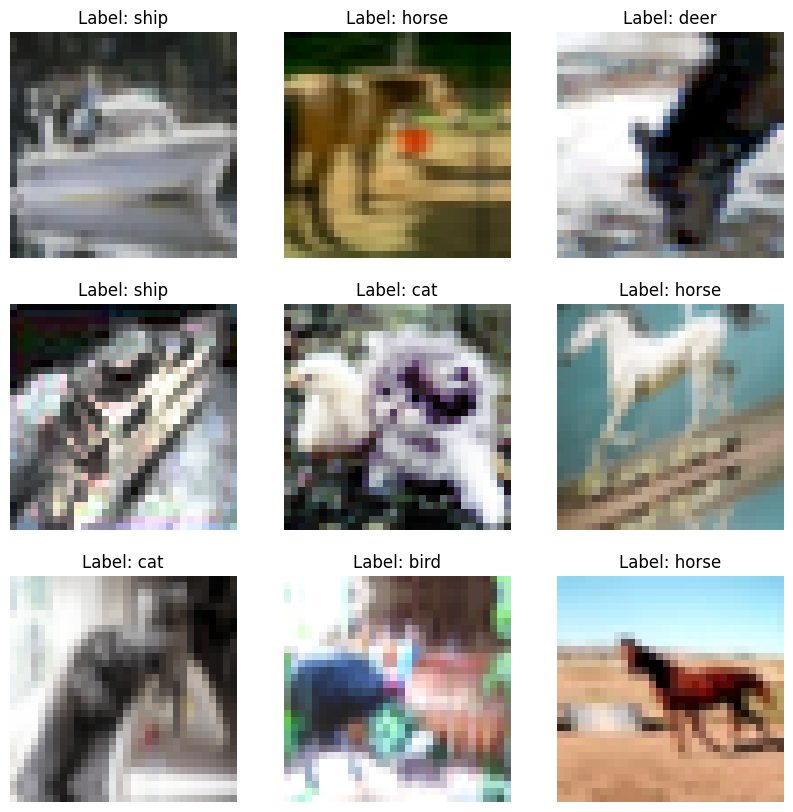

In [11]:
sample_images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {classes[int(labels[i])]}")
    plt.axis("off")

### Train the Model

In [12]:
import math

def build_efficientnet(input_shape=(32, 32, 3), num_classes=10, width_coefficient=1.0, depth_coefficient=1.0, dropout_rate=0.3):

    def round_filters(filters):
        # round number of filters based on width coefficient
        filters *= width_coefficient
        new_filters = int(filters + 4) // 8 * 8
        new_filters = max(8, new_filters)
        if new_filters < 0.9 * filters:
            new_filters += 8
        return int(new_filters)

    def round_repeats(repeats):
        # round number of repeats based on depth coefficient
        return int(math.ceil(depth_coefficient * repeats))

    # base parameters for EfficientNet-B0
    base_block_args = [
        [1,  16,  1, 1, 3],  # MBConv1, 3x3
        [6,  24,  2, 1, 3],  # MBConv6, 3x3
        [6,  40,  2, 2, 5],  # MBConv6, 5x5
        [6,  80,  3, 1, 3],  # MBConv6, 3x3
        [6, 112,  3, 1, 5],  # MBConv6, 5x5
        [6, 192,  4, 2, 5],  # MBConv6, 5x5
        [6, 320,  1, 1, 3]   # MBConv6, 3x3
    ]

    inputs = layers.Input(shape=input_shape)

    # initial block
    x = initial_block(inputs, round_filters(32), stride=1)

    # build MBConv blocks
    for expand_ratio, channels, repeats, stride, kernel_size in base_block_args:
        out_channels = round_filters(channels)
        repeats = round_repeats(repeats)

        # first block needs to handle stride
        x = mbconv_block(
            x,
            output_channels=out_channels,
            expansion_ratio=expand_ratio,
            kernel_size=kernel_size,
            stride=stride,
            drop_rate=dropout_rate
        )

        # remaining blocks
        if repeats > 1:
            for _ in range(repeats - 1):
                x = mbconv_block(
                    x,
                    output_channels=out_channels,
                    expansion_ratio=expand_ratio,
                    kernel_size=kernel_size,
                    stride=1,
                    drop_rate=dropout_rate
                )

    # final convolution
    x = layers.Conv2D(round_filters(1280),
                     kernel_size=1,
                     padding='same',
                     use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # final classification
    outputs = head_block(x, num_classes, dropout_rate)

    # create model
    model = Model(inputs, outputs, name='efficientnet')
    return model

In [13]:
def train_efficientnet(train_ds:tf.data.Dataset, val_ds:tf.data.Dataset) -> tuple:
    # build model
    model = build_efficientnet(
        input_shape=(32, 32, 3),
        num_classes=10,
        width_coefficient=1.2,
        depth_coefficient=1.1,
    )

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'efficientnet_cifar10.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    callbacks = [
        early_stopping,
        lr_scheduler,
        model_checkpoint
    ]

    # train the model
    history = model.fit(
        train_ds,
        epochs=150,
        validation_data=val_ds,
        callbacks=callbacks
    )

    return model, history

In [14]:
model, history = train_efficientnet(train_ds, val_ds)

Epoch 1/150
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.1322 - loss: 2.3168
Epoch 1: val_accuracy improved from -inf to 0.23480, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 309s 232ms/step - accuracy: 0.1323 - loss: 2.3166 - val_accuracy: 0.2348 - val_loss: 1.9615 - learning_rate: 0.0010
Epoch 2/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.2316 - loss: 1.9737
Epoch 2: val_accuracy improved from 0.23480 to 0.28600, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.2316 - loss: 1.9736 - val_accuracy: 0.2860 - val_loss: 1.9466 - learning_rate: 0.0010
Epoch 3/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3341 - loss: 1.7717
Epoch 3: val_accuracy improved from 0.28600 to 0.43140, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.3342 - loss: 1.7715 - val_accuracy: 0.4314 - val_loss: 1.5671 - learning_rate: 0.0010
Epoch 4/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4520 - loss: 1.4913
Epoch 4: val_accuracy improved from 0.43140 to 0.52920, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.4521 - loss: 1.4911 - val_accuracy: 0.5292 - val_loss: 1.3604 - learning_rate: 0.0010
Epoch 5/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5381 - loss: 1.2834
Epoch 5: val_accuracy improved from 0.52920 to 0.67740, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.5381 - loss: 1.2833 - val_accuracy: 0.6774 - val_loss: 0.9180 - learning_rate: 0.0010
Epoch 6/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6012 - loss: 1.1313
Epoch 6: val_accuracy improved from 0.67740 to 0.73100, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.6012 - loss: 1.1313 - val_accuracy: 0.7310 - val_loss: 0.7676 - learning_rate: 0.0010
Epoch 7/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6416 - loss: 1.0089
Epoch 7: val_accuracy improved from 0.73100 to 0.75760, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.6417 - loss: 1.0088 - val_accuracy: 0.7576 - val_loss: 0.7085 - learning_rate: 0.0010
Epoch 8/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6740 - loss: 0.9281
Epoch 8: val_accuracy did not improve from 0.75760
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.6740 - loss: 0.9281 - val_accuracy: 0.7514 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 9/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6995 - loss: 0.8588
Epoch 9: val_accuracy improved from 0.75760 to 0.79000, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.6996 - loss: 0.8587 - val_accuracy: 0.7900 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 10/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7294 - loss: 0.7784
Epoch 10: val_accuracy did not improve from 0.79000
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.7294 - loss: 0.7784 - val_accuracy: 0.7808 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 11/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7406 - loss: 0.7348
Epoch 11: val_accuracy improved from 0.79000 to 0.81420, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.7407 - loss: 0.7348 - val_accuracy: 0.8142 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 12/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7627 - loss: 0.6903
Epoch 12: val_accuracy improved from 0.81420 to 0.82340, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.7626 - loss: 0.6903 - val_accuracy: 0.8234 - val_loss: 0.5233 - learning_rate: 0.0010
Epoch 13/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7728 - loss: 0.6520
Epoch 13: val_accuracy improved from 0.82340 to 0.84140, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.7728 - loss: 0.6520 - val_accuracy: 0.8414 - val_loss: 0.4537 - learning_rate: 0.0010
Epoch 14/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7827 - loss: 0.6280
Epoch 14: val_accuracy improved from 0.84140 to 0.84460, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.7827 - loss: 0.6280 - val_accuracy: 0.8446 - val_loss: 0.4533 - learning_rate: 0.0010
Epoch 15/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7898 - loss: 0.6004
Epoch 15: val_accuracy did not improve from 0.84460
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.7898 - loss: 0.6004 - val_accuracy: 0.8190 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 16/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7887 - loss: 0.6107
Epoch 16: val_accuracy improved from 0.84460 to 0.84600, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.7887 - loss: 0.6107 - val_accuracy: 0.8460 - val_loss: 0.4505 - learning_rate: 0.0010
Epoch 17/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8061 - loss: 0.5602
Epoch 17: val_accuracy did not improve from 0.84600
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 106ms/step - accuracy: 0.8061 - loss: 0.5602 - val_accuracy: 0.8458 - val_loss: 0.4436 - learning_rate: 0.0010
Epoch 18/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8143 - loss: 0.5375
Epoch 18: val_accuracy improved from 0.84600 to 0.86240, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 107ms/step - accuracy: 0.8143 - loss: 0.5375 - val_accuracy: 0.8624 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 19/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8254 - loss: 0.5158
Epoch 19: val_accuracy improved from 0.86240 to 0.86740, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.8254 - loss: 0.5158 - val_accuracy: 0.8674 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 20/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8296 - loss: 0.4887
Epoch 20: val_accuracy improved from 0.86740 to 0.87980, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.8296 - loss: 0.4887 - val_accuracy: 0.8798 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 21/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8373 - loss: 0.4687
Epoch 21: val_accuracy did not improve from 0.87980
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.8373 - loss: 0.4687 - val_accuracy: 0.8704 - val_loss: 0.3793 - learning_rate: 0.0010
Epoch 22/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8440 - loss: 0.4592
Epoch 22: val_accuracy did not improve from 0.87980
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.8440 - loss: 0.4592 - val_accuracy: 0.8540 - val_loss: 0.4290 - learning_rate: 0.0010
Epoch 23/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8447 - loss: 0.4451
Epoch 23: val_accuracy improved from 0.87980 to 0.88860, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 107ms/step - accuracy: 0.8447 - loss: 0.4452 - val_accuracy: 0.8886 - val_loss: 0.3329 - learning_rate: 0.0010
Epoch 24/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8513 - loss: 0.4307
Epoch 24: val_accuracy did not improve from 0.88860
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.8513 - loss: 0.4307 - val_accuracy: 0.8862 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 25/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8593 - loss: 0.4108
Epoch 25: val_accuracy did not improve from 0.88860
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.8593 - loss: 0.4108 - val_accuracy: 0.8754 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 26/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8574 - loss: 0.4140
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 26: val_accuracy did not improve from 0.88860
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 106ms/step - accuracy: 0.8575 

704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.8818 - loss: 0.3369 - val_accuracy: 0.9112 - val_loss: 0.2607 - learning_rate: 2.0000e-04
Epoch 28/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8992 - loss: 0.2960
Epoch 28: val_accuracy improved from 0.91120 to 0.91420, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.8992 - loss: 0.2960 - val_accuracy: 0.9142 - val_loss: 0.2509 - learning_rate: 2.0000e-04
Epoch 29/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9013 - loss: 0.2878
Epoch 29: val_accuracy improved from 0.91420 to 0.91640, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.9013 - loss: 0.2877 - val_accuracy: 0.9164 - val_loss: 0.2435 - learning_rate: 2.0000e-04
Epoch 30/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9081 - loss: 0.2654
Epoch 30: val_accuracy improved from 0.91640 to 0.91940, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.9081 - loss: 0.2655 - val_accuracy: 0.9194 - val_loss: 0.2454 - learning_rate: 2.0000e-04
Epoch 31/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9066 - loss: 0.2681
Epoch 31: val_accuracy did not improve from 0.91940
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9066 - loss: 0.2681 - val_accuracy: 0.9188 - val_loss: 0.2416 - learning_rate: 2.0000e-04
Epoch 32/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9084 - loss: 0.2641
Epoch 32: val_accuracy did not improve from 0.91940
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9084 - loss: 0.2641 - val_accuracy: 0.9180 - val_loss: 0.2417 - learning_rate: 2.0000e-04
Epoch 33/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9129 - loss: 0.2543
Epoch 33: val_accuracy improved from 0.91940 to 0.92040, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.9129 - loss: 0.2543 - val_accuracy: 0.9204 - val_loss: 0.2367 - learning_rate: 2.0000e-04
Epoch 34/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9119 - loss: 0.2537
Epoch 34: val_accuracy did not improve from 0.92040
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.9119 - loss: 0.2537 - val_accuracy: 0.9184 - val_loss: 0.2400 - learning_rate: 2.0000e-04
Epoch 35/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9159 - loss: 0.2479
Epoch 35: val_accuracy did not improve from 0.92040
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.9158 - loss: 0.2479 - val_accuracy: 0.9192 - val_loss: 0.2413 - learning_rate: 2.0000e-04
Epoch 36/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9155 - loss: 0.2415
Epoch 36: val_accuracy improved from 0.92040 to 0.92240, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.9155 - loss: 0.2415 - val_accuracy: 0.9224 - val_loss: 0.2307 - learning_rate: 2.0000e-04
Epoch 37/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9168 - loss: 0.2411
Epoch 37: val_accuracy did not improve from 0.92240
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9167 - loss: 0.2412 - val_accuracy: 0.9224 - val_loss: 0.2314 - learning_rate: 2.0000e-04
Epoch 38/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9186 - loss: 0.2351
Epoch 38: val_accuracy did not improve from 0.92240
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 106ms/step - accuracy: 0.9186 - loss: 0.2351 - val_accuracy: 0.9216 - val_loss: 0.2324 - learning_rate: 2.0000e-04
Epoch 39/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9214 - loss: 0.2287
Epoch 39: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 39: val_accuracy did not improve from 0.92240
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accur

704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.9311 - loss: 0.2017 - val_accuracy: 0.9226 - val_loss: 0.2246 - learning_rate: 4.0000e-05
Epoch 42/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9280 - loss: 0.2059
Epoch 42: val_accuracy improved from 0.92260 to 0.92660, saving model to efficientnet_cifar10.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 107ms/step - accuracy: 0.9280 - loss: 0.2059 - val_accuracy: 0.9266 - val_loss: 0.2252 - learning_rate: 4.0000e-05
Epoch 43/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9303 - loss: 0.2052
Epoch 43: val_accuracy did not improve from 0.92660
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.9303 - loss: 0.2052 - val_accuracy: 0.9254 - val_loss: 0.2264 - learning_rate: 4.0000e-05
Epoch 44/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9303 - loss: 0.2047
Epoch 44: val_accuracy did not improve from 0.92660
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.9303 - loss: 0.2047 - val_accuracy: 0.9260 - val_loss: 0.2242 - learning_rate: 4.0000e-05
Epoch 45/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9313 - loss: 0.1985
Epoch 45: val_accuracy did not improve from 0.92660
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9313 - loss: 0.1985 - val_accuracy: 0.9260 - val_loss: 0.2240 - learning

704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.9350 - loss: 0.1922 - val_accuracy: 0.9282 - val_loss: 0.2227 - learning_rate: 4.0000e-05
Epoch 48/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9338 - loss: 0.1930
Epoch 48: val_accuracy did not improve from 0.92820
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9338 - loss: 0.1930 - val_accuracy: 0.9278 - val_loss: 0.2250 - learning_rate: 4.0000e-05
Epoch 49/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9319 - loss: 0.2018
Epoch 49: val_accuracy did not improve from 0.92820
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9319 - loss: 0.2018 - val_accuracy: 0.9270 - val_loss: 0.2226 - learning_rate: 4.0000e-05
Epoch 50/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9330 - loss: 0.1942
Epoch 50: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 50: val_accuracy did not improve from 0.92820
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 106ms/step - accura

704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 108ms/step - accuracy: 0.9356 - loss: 0.1896 - val_accuracy: 0.9288 - val_loss: 0.2226 - learning_rate: 8.0000e-06
Epoch 54/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9354 - loss: 0.1912
Epoch 54: val_accuracy did not improve from 0.92880
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.9354 - loss: 0.1912 - val_accuracy: 0.9286 - val_loss: 0.2221 - learning_rate: 1.6000e-06
Epoch 55/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9339 - loss: 0.1947
Epoch 55: val_accuracy did not improve from 0.92880
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9339 - loss: 0.1947 - val_accuracy: 0.9278 - val_loss: 0.2227 - learning_rate: 1.6000e-06
Epoch 56/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9338 - loss: 0.1933
Epoch 56: val_accuracy did not improve from 0.92880
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9338 - loss: 0.1933 - val_accuracy: 0.9280 - val_loss: 0.2236 - learning

704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.9349 - loss: 0.1937 - val_accuracy: 0.9294 - val_loss: 0.2217 - learning_rate: 1.6000e-06
Epoch 58/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9329 - loss: 0.1904
Epoch 58: val_accuracy did not improve from 0.92940
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 106ms/step - accuracy: 0.9329 - loss: 0.1904 - val_accuracy: 0.9280 - val_loss: 0.2229 - learning_rate: 1.6000e-06
Epoch 59/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9364 - loss: 0.1838
Epoch 59: val_accuracy did not improve from 0.92940
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.9363 - loss: 0.1838 - val_accuracy: 0.9278 - val_loss: 0.2230 - learning_rate: 1.6000e-06
Epoch 60/150
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9371 - loss: 0.1845
Epoch 60: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 60: val_accuracy did not improve from 0.92940
704/704 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.9371 - los

### Evaluate the Model

In [15]:
model.summary()

Model: "efficientnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 40)     │          1,080 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 40)     │            160 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 40)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 32, 32, 40)     │            360 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 40)     │            160 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 40)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 40)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10)             │            410 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 10)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 40)             │            440 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 40)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 40)       │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 32, 32, 40)     │              0 │ activation_1[0][0],    │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 24)     │            960 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 24)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1   

 Total params: 52,534,416 (200.40 MB)

 Trainable params: 17,486,394 (66.71 MB)

 Non-trainable params: 75,232 (293.88 KB)

 Optimizer params: 34,972,790 (133.41 MB)

In [16]:
_, acc = model.evaluate(train_ds_original)
print("Original Training Accuracy = ", (acc * 100.0), "%")

704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9946 - loss: 0.0290
Original Training Accuracy =  99.4599997997284 %


In [17]:
_, acc = model.evaluate(val_ds)
print("Validation Accuracy = ", (acc * 100.0), "%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9266 - loss: 0.2205
Validation Accuracy =  92.91999936103821 %


In [18]:
_, acc = model.evaluate(test_ds)
print("Test Accuracy = ", (acc * 100.0), "%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.9266 - loss: 0.2238
Test Accuracy =  92.65999794006348 %


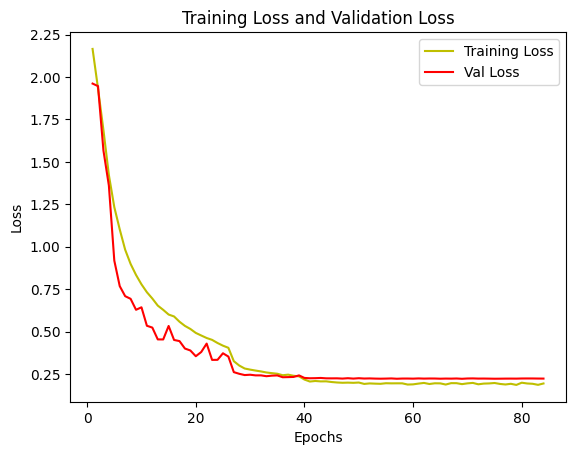

In [19]:
# plot the loss curve
loss_curve = history.history["loss"]
val_loss_curve = history.history["val_loss"]
epochs = range(1, len(loss_curve) + 1)
plt.plot(epochs, loss_curve, 'y', label="Training Loss")
plt.plot(epochs, val_loss_curve, 'r', label="Val Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

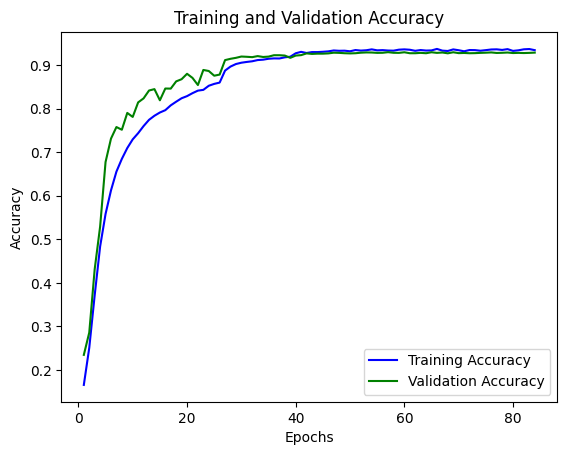

In [20]:
# plot the accuracy curve
acc_curve = history.history["accuracy"]
val_acc_curve = history.history["val_accuracy"]
epochs = range(1, len(acc_curve) + 1)
plt.plot(epochs, acc_curve, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_curve, 'g', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred_classes = [np.argmax(element) for element in y_pred]

print(classification_report(y_test, y_pred_classes))

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1000
           1       0.95      0.97      0.96      1000
           2       0.92      0.90      0.91      1000
           3       0.86      0.83      0.84      1000
           4       0.93      0.92      0.92      1000
           5       0.88      0.88      0.88      1000
           6       0.93      0.96      0.94      1000
           7       0.96      0.94      0.95      1000
           8       0.96      0.96      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



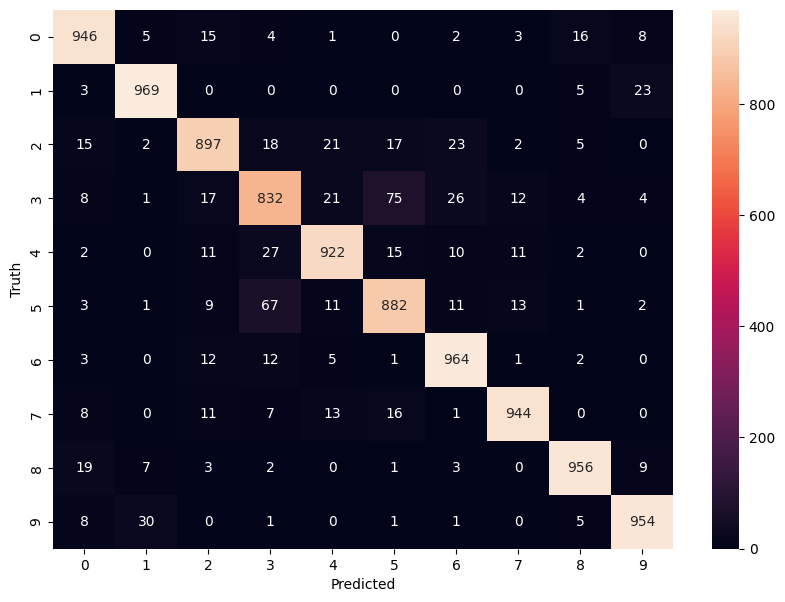

In [22]:
cm = tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### EfficientNet Performance Report on CIFAR-10 Dataset

#### Model Architecture and Training Details

The EfficientNet model implemented in this study contains **17.4 million parameters**, significantly higher than the 4M parameter model (B0) described in the original paper. Training was configured for 150 epochs with early stopping, which activated at the 84th epoch. The best model performance was observed at epoch 69.

#### Comprehensive Model Comparison

Below is a table comparing all models trained on the CIFAR-10 dataset:

| Model | Training Accuracy (%) | Test Accuracy (%) | Parameters (M) | Epochs | Training-Test Gap (%) |
|-------|----------------------|-------------------|----------------|---------|---------------------|
| ResNet | 99.93 | 93.19 | 21.2 | 53* | 6.74 |
| **EfficientNet** | **99.45** | **92.65** | **17.4** | **69†** | **6.8** |
| MobileNet | 99.94 | 90.75 | 1.0 | 65** | 9.19 |
| MobileNetBig | 99.87 | 90.10 | 3.2 | 58*** | 9.77 |
| Inception + BatchNorm | 99.31 | 89.87 | 1.6 | 50 | 9.44 |
| VGG + BatchNorm | 95.29 | 86.58 | 33.6 | 50 | 8.71 |
| AlexNet | 81.97 | 77.53 | 3.2 | 50 | 4.44 |

*ResNet was initially configured for 150 epochs but stopped at 68, with best performance at epoch 53.  
**MobileNet was initially configured for 150 epochs but stopped at 80, with best performance at epoch 65.  
***MobileNetBig was initially configured for 150 epochs but stopped at 73, with best performance at epoch 58.  
†EfficientNet was initially configured for 150 epochs but stopped at 84, with best performance at epoch 69.

#### Key Observations

##### 1. Model Accuracy Analysis

- **ResNet** remains the best performing model with 93.19% test accuracy, but requires 21.2M parameters.
- **EfficientNet** achieves the second-best test accuracy (92.65%) with 17.4M parameters.
- **MobileNet** provides excellent efficiency with only 1.0M parameters while achieving 90.75% test accuracy.
- **AlexNet** shows the lowest accuracy but also the smallest training-test gap, suggesting less overfitting.

##### 2. Overfitting Analysis

The training-test accuracy gap indicates the level of overfitting:

1. **AlexNet**: Lowest gap (4.44%) - least overfitting, but also poorest performance
2. **EfficientNet**: 6.8% gap
3. **ResNet**: 6.74% gap
4. **VGG**: 8.71% gap
5. **Inception**: 9.44% gap
6. **MobileNet**: 9.19% gap
7. **MobileNetBig**: Highest gap (9.77%) - most overfitting

#### Conclusions and Recommendations

1. **ResNet** provides the highest accuracy but at the cost of a large model size.
2. **EfficientNet** shows competitive performance but our implementation is larger than optimal.
3. **MobileNet** offers the best accuracy-to-parameter ratio for resource-constrained applications.